In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [2]:
df = pd.read_csv("../data/fromAPI/cleaned_hourly_all3.csv")

In [3]:
date_format = "%Y-%m-%d %H:%M:%S"
df["arrival_plan"] = pd.to_datetime(df["arrival_plan"], format=date_format)
df["departure_plan"] = pd.to_datetime(df["departure_plan"], format=date_format)
df["arrival_change"] = pd.to_datetime(df["arrival_change"], format=date_format)
df["departure_change"] = pd.to_datetime(df["departure_change"], format=date_format)
df["departure_plan_hour"] = df["departure_plan"].dt.hour
df["departure_plan_date"] = df["departure_plan"].dt.date

df = df.dropna(subset=["departure_plan"])
df.loc[:, "departure_plan_hour"] = df["departure_plan"].dt.hour
df.loc[:, "departure_plan_datetime"] = (
    df["departure_plan_date"].astype(str) + ' ' +
    df["departure_plan_hour"].astype(str) + ':00:00'
)
df.loc[:, "departure_plan_datetime"] = pd.to_datetime(df["departure_plan_datetime"], format=date_format)

df.head()


,ID,line,path,eva_nr,category,station,state,city,zip,long,...,arrival_change,departure_change,arrival_delay_m,departure_delay_m,info,arrival_delay_check,departure_delay_check,departure_plan_hour,departure_plan_date,departure_plan_datetime
0,1573967790757085557-2407072312-14,20,Stolberg(Rheinl)Hbf Gl.44|Eschweiler-St.Jöris|...,8000001,2,Aachen Hbf,Nordrhein-Westfalen,Aachen,52064,6.091499,...,2024-07-08 00:03:00,2024-07-08 00:04:00,3,3,NaN,on_time,on_time,0,2024-07-08,2024-07-08 00:00:00
1,349781417030375472-2407080017-1,18,NaN,8000001,2,Aachen Hbf,Nordrhein-Westfalen,Aachen,52064,6.091499,...,NaT,NaT,0,0,NaN,on_time,on_time,0,2024-07-08,2024-07-08 00:00:00
2,7157250219775883918-2407072120-25,1,Hamm(Westf)Hbf|Kamen|Kamen-Methler|Dortmund-Ku...,8000406,4,Aachen-Rothe Erde,Nordrhein-Westfalen,Aachen,52066,6.116475,...,2024-07-08 00:03:00,2024-07-08 00:04:00,0,0,NaN,on_time,on_time,0,2024-07-08,2024-07-08 00:00:00
3,349781417030375472-2407080017-2,18,Aachen Hbf,8000404,5,Aachen West,Nordrhein-Westfalen,Aachen,52072,6.070715,...,NaT,NaT,0,0,NaN,on_time,on_time,0,2024-07-08,2024-07-08 00:00:00
4,1983158592123451570-2407080010-3,33,Herzogenrath|Kohlscheid,8000404,5,Aachen West,Nordrhein-Westfalen,Aachen,52072,6.070715,...,2024-07-08 00:20:00,2024-07-08 00:21:00,0,0,NaN,on_time,on_time,0,2024-07-08,2024-07-08 00:00:00


In [4]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [5]:
tsa = df[["departure_plan_datetime","departure_delay_m","departure_plan_hour"]].groupby("departure_plan_datetime", as_index=False).mean()
tsa = tsa.set_index('departure_plan_datetime').asfreq('h', fill_value=tsa.departure_delay_m.mean())
# tsa.loc["2024-06-24 15:00:00","departure_delay_m"] = tsa[tsa["departure_plan_hour"] == 15].departure_delay_m.median()
# tsa.loc["2024-06-24 16:00:00","departure_delay_m"] = tsa[tsa["departure_plan_hour"] == 16].departure_delay_m.median()
# tsa.loc["2024-06-24 17:00:00","departure_delay_m"] = tsa[tsa["departure_plan_hour"] == 17].departure_delay_m.median()
# tsa.loc["2024-06-24 18:00:00","departure_delay_m"] = tsa[tsa["departure_plan_hour"] == 18].departure_delay_m.median()
# tsa.loc["2024-06-24 17:00:00","departure_plan_hour"] = 17.0
# tsa.loc["2024-06-24 18:00:00","departure_plan_hour"] = 18.0
tsa.sort_index(inplace=True)



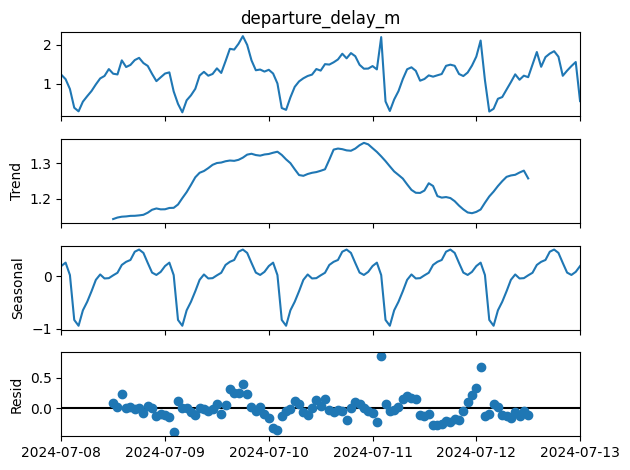

In [6]:
decomposition = seasonal_decompose(tsa['departure_delay_m'], model='additive', period=24)
decomposition.plot()
plt.show()

In [7]:
tsa["departure_delay_m"] = scaler.fit_transform(tsa[["departure_delay_m"]])
tsa.head()

,departure_delay_m,departure_plan_hour
departure_plan_datetime,,
2024-07-08 00:00:00,0.494009,0.0
2024-07-08 01:00:00,0.435369,1.0
2024-07-08 02:00:00,0.306128,2.0
2024-07-08 03:00:00,0.060443,3.0
2024-07-08 04:00:00,0.013086,4.0


In [8]:
from scipy.stats import zscore

statelist = df.state.unique()
frames = {}
for state in statelist:
    frames[state] = df[df["state"] == state]
    frames[state] = frames[state][["departure_plan_datetime","departure_delay_m","departure_plan_hour"]].groupby("departure_plan_datetime", as_index=False).mean()
    frames[state]['zscore'] = zscore(frames[state]['departure_delay_m'])
    # Identify outliers with Z-score threshold of 3
    outliers = frames[state][np.abs(frames[state]['zscore']) > 3]
    # Replace outliers with the median of the surrounding values
    for index in outliers.index:
        frames[state].at[index, 'departure_delay_m'] = frames[state]['departure_delay_m'].median()#only flattening the most excessive spikes for some states
    # Drop the zscore column as it's no longer needed
    frames[state] = frames[state].drop(columns=['zscore'])
    frames[state]['departure_delay_m'] = frames[state]['departure_delay_m'].rolling(window=3).mean()
    frames[state] = frames[state].set_index('departure_plan_datetime').asfreq('h', fill_value=frames[state].departure_delay_m.mean())
    # frames[state].loc["2024-06-24 15:00:00","departure_delay_m"] = frames[state][frames[state]["departure_plan_hour"] == 15].departure_delay_m.median()
    # frames[state].loc["2024-06-24 16:00:00","departure_delay_m"] = frames[state][frames[state]["departure_plan_hour"] == 16].departure_delay_m.median()
    # frames[state].loc["2024-06-24 17:00:00","departure_delay_m"] = frames[state][frames[state]["departure_plan_hour"] == 17].departure_delay_m.median()
    # frames[state].loc["2024-06-24 18:00:00","departure_delay_m"] = frames[state][frames[state]["departure_plan_hour"] == 18].departure_delay_m.median()
    frames[state]["departure_delay_m"] = scaler.fit_transform(frames[state][["departure_delay_m"]])


In [9]:
result = adfuller(tsa['departure_delay_m'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])
if result[1] < 0.05:
    print("Series is stationary. No differencing needed.")

ADF Statistic: -5.588014645855068
p-value: 1.349020702592071e-06
Critical Values: {'1%': -3.4912451337340342, '5%': -2.8881954545454547, '10%': -2.5809876033057852}
Series is stationary. No differencing needed.


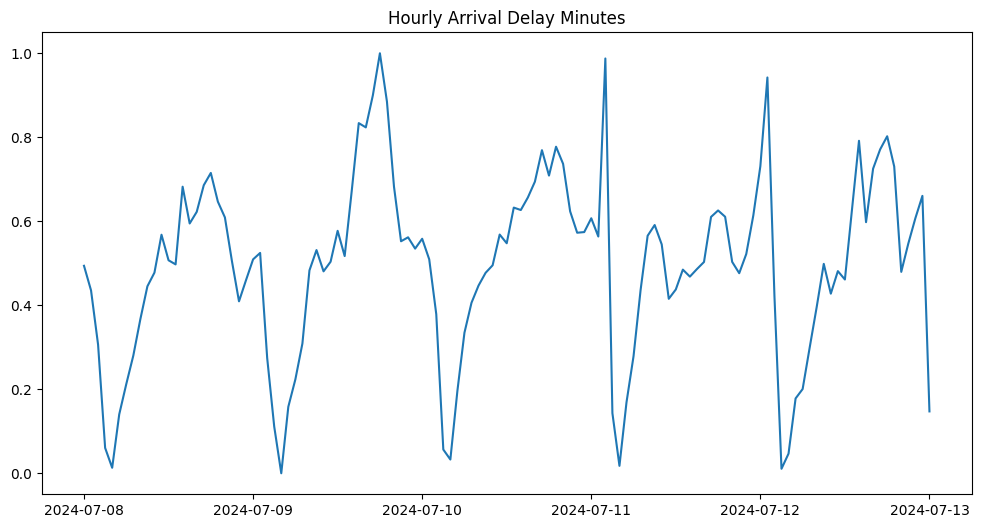

In [10]:
# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(tsa['departure_delay_m'])
plt.title('Hourly Arrival Delay Minutes')
plt.show()

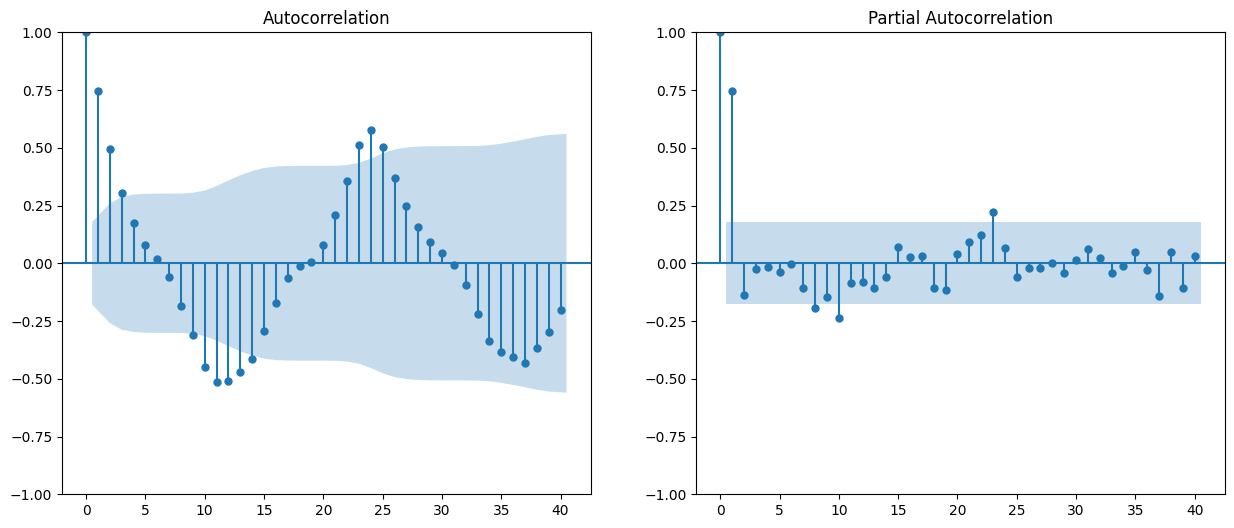

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF and PACF plots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
plot_acf(tsa['departure_delay_m'], lags=40, ax=axes[0])
plot_pacf(tsa['departure_delay_m'], lags=40, ax=axes[1])
plt.show()

Autocorrelation and partial autocrrelaction suggets to use between 1-3 for p and q parameters

In [12]:
from warnings import filterwarnings
filterwarnings('ignore')

In [13]:
trainpart = 0.7

In [14]:
i_split = int(trainpart * len(tsa))
tsa_train, tsa_test = tsa.iloc[:i_split,:], tsa.iloc[i_split:,:]
print('all forecasts must be {} periods long.'.format(len(tsa_test)))

all forecasts must be 37 periods long.


In [15]:
import itertools
import math
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define the range of values for p, d, q, P, D, Q, and m
p_values = range(1, 4)  # Autoregressive order
d_values = [0]          # Differencing order
q_values = range(1, 4)  # Moving average order
P_values = range(1, 4)  # Seasonal autoregressive order
D_values = range(0, 1)  # Seasonal differencing order
Q_values = range(1, 4)  # Seasonal moving average order
m_values = [24]         # Seasonal period

# Create all possible combinations of SARIMA parameters
param_combinations = list(itertools.product(p_values, 
                                            d_values, 
                                            q_values, 
                                            P_values, 
                                            D_values, 
                                            Q_values, 
                                            m_values))

# Initialize AIC with a large value
best_aic = float("inf")  
best_params = None

In [16]:
# Perform grid search
for params in param_combinations:
    order = params[:3]
    seasonal_order = params[3:]
    
    try:
        model = SARIMAX(tsa_train["departure_delay_m"], 
                               order=order, 
                               seasonal_order=seasonal_order)
        result = model.fit(disp=False, maxiter=100)
        aic = result.aic
        
        # Ensure the convergence of the model
        if not math.isinf(result.zvalues.mean()):
            print(order, seasonal_order, aic)
        
            if aic < best_aic:
                best_aic = aic
                best_params = params
                
        else:
            print(order, seasonal_order, 'not converged')

    except:
        continue

# Print the best parameters and AIC
print("Best Parameters:", best_params)
print("Best AIC:", best_aic)

(1, 0, 1) (1, 0, 1, 24) -100.34976157843805
(1, 0, 1) (1, 0, 2, 24) -98.43968755223895
(1, 0, 1) (1, 0, 3, 24) -96.4041027784441
(1, 0, 1) (2, 0, 1, 24) -98.44445482326842
(1, 0, 1) (2, 0, 2, 24) -96.43450564763539
(1, 0, 1) (2, 0, 3, 24) -94.4877976165407
(1, 0, 1) (3, 0, 1, 24) -96.42971112382602
(1, 0, 1) (3, 0, 2, 24) -94.42730370617707
(1, 0, 1) (3, 0, 3, 24) -92.50334806116598
(1, 0, 2) (1, 0, 1, 24) -99.6789626271576
(1, 0, 2) (1, 0, 2, 24) -97.9906911945713
(1, 0, 2) (1, 0, 3, 24) -95.88444755706031
(1, 0, 2) (2, 0, 1, 24) -97.98737360211162
(1, 0, 2) (2, 0, 2, 24) -95.97166293331036
(1, 0, 2) (2, 0, 3, 24) -94.0729576951079
(1, 0, 2) (3, 0, 1, 24) -95.96246214940089
(1, 0, 2) (3, 0, 2, 24) -93.96156328502185
(1, 0, 2) (3, 0, 3, 24) -92.09603176028418
(1, 0, 3) (1, 0, 1, 24) -97.85560649207657
(1, 0, 3) (1, 0, 2, 24) -96.17756677901815
(1, 0, 3) (1, 0, 3, 24) -94.07774424197113
(1, 0, 3) (2, 0, 1, 24) -96.17484154971056
(1, 0, 3) (2, 0, 2, 24) -94.15509579734554
(1, 0, 3) (2, 0

In [27]:
# refit the SARIMA model
model = SARIMAX(tsa_train['departure_delay_m'], 
                order=best_params[:3], 
                seasonal_order=(3,0,1,24), 
                )
model_fit = model.fit(maxiter=200)



 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.02838D-01    |proj g|=  3.31369D-01

At iterate    5    f= -6.24137D-01    |proj g|=  1.85786D-01

At iterate   10    f= -6.43099D-01    |proj g|=  6.46306D-02

At iterate   15    f= -6.46953D-01    |proj g|=  1.07767D-01

At iterate   20    f= -6.57498D-01    |proj g|=  5.19027D-02

At iterate   25    f= -6.60748D-01    |proj g|=  6.47289D-02

At iterate   30    f= -6.60915D-01    |proj g|=  2.50364D-02

At iterate   35    f= -6.62667D-01    |proj g|=  1.83194D-01

At iterate   40    f= -6.68158D-01    |proj g|=  3.70984D-02

At iterate   45    f= -6.70087D-01    |proj g|=  3.45969D-02

At iterate   50    f= -6.78666D-01    |proj g|=  8.43890D-02

At iterate   55    f= -6.81278D-01    |proj g|=  3.28017D-02

At iterate   60    f= -6.87141D-01    |proj g|=  4.68027D-02

At iterate   65    f= -6.9

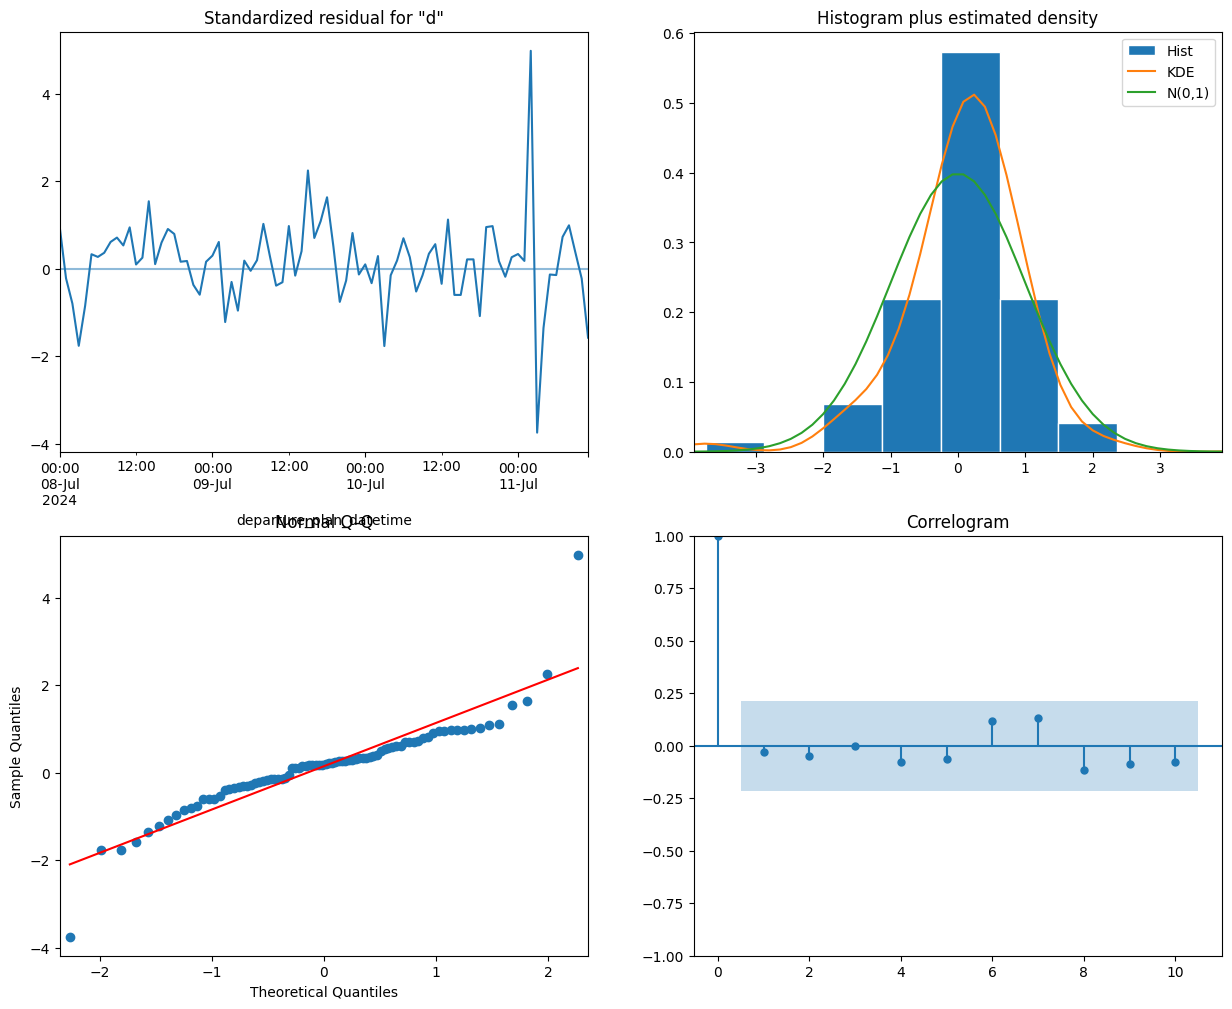

In [28]:
# Diagnostic plots
model_fit.plot_diagnostics(figsize=(15, 12))
plt.show()

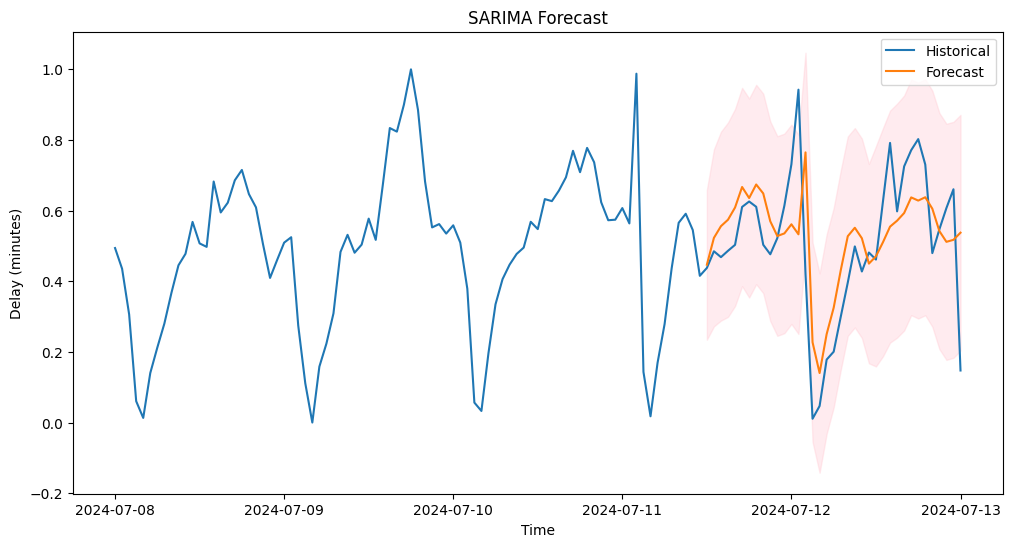

In [29]:
forecast_steps = len(tsa_test)
forecast = model_fit.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=tsa_test.index[0], periods=forecast_steps, freq='h')[0:]
forecast_series = pd.Series(forecast.predicted_mean, index=forecast_index)
confidence_intervals = forecast.conf_int()

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(tsa['departure_delay_m'], label='Historical')
plt.plot(forecast_series, label='Forecast')
plt.fill_between(forecast_index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='pink', alpha=0.3)
plt.title('SARIMA Forecast')
plt.xlabel('Time')
plt.ylabel('Delay (minutes)')
plt.legend()
plt.show()

In [30]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(tsa_test["departure_delay_m"], forecast_series))
print(f'RMSE: {rmse}')
print(f"predictability: {tsa['departure_delay_m'].std()/rmse}")


RMSE: 0.15172727161789656
predictability: 1.4450446615721229


# Searching for Systematic Issues

In [31]:
from warnings import filterwarnings
filterwarnings('ignore')

In [32]:
frames_train = {}
frames_test = {}
frames_forecast_l = {}
for state, data in frames.items():
    i_split = int(0.6 * len(data))
    frames_train[state], frames_test[state] = frames[state].iloc[:i_split,:], frames[state].iloc[i_split:,:]
    frames_forecast_l[state] = len(frames_test[state])

In [33]:
models = {}
for state, data in frames_train.items():
    model = SARIMAX(data['departure_delay_m'], 
                    order=best_params[:3], 
                    seasonal_order=(3,0,1,24), 
                    )
    fit = model.fit(disp=False, maxiter=200)
    models[state] = fit
    print(f"fitted to {state}")

    if math.isinf(fit.zvalues.mean()):
        print(f'{state}not converged')

fitted to Nordrhein-Westfalen
fitted to Baden-Württemberg
fitted to Niedersachsen
fitted to Schleswig-Holstein
fitted to Bayern
fitted to Berlin
fitted to Hamburg
fitted to Thüringen
fitted to Rheinland-Pfalz
fitted to Mecklenburg-Vorpommern
fitted to Sachsen
fitted to Sachsen-Anhalt
fitted to Brandenburg
fitted to Hessen
fitted to Saarland
fitted to Bremen


calc for Nordrhein-Westfalen


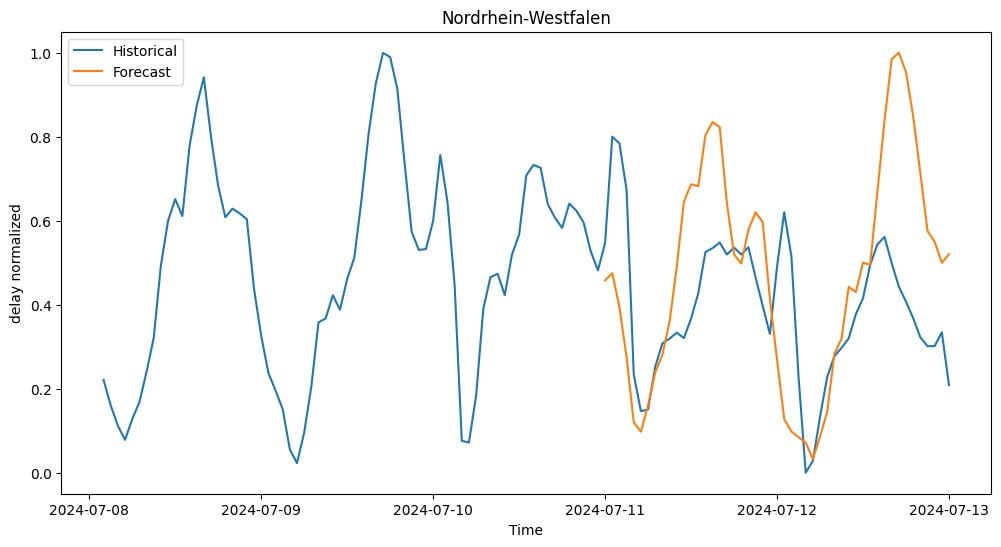

calc for Baden-Württemberg


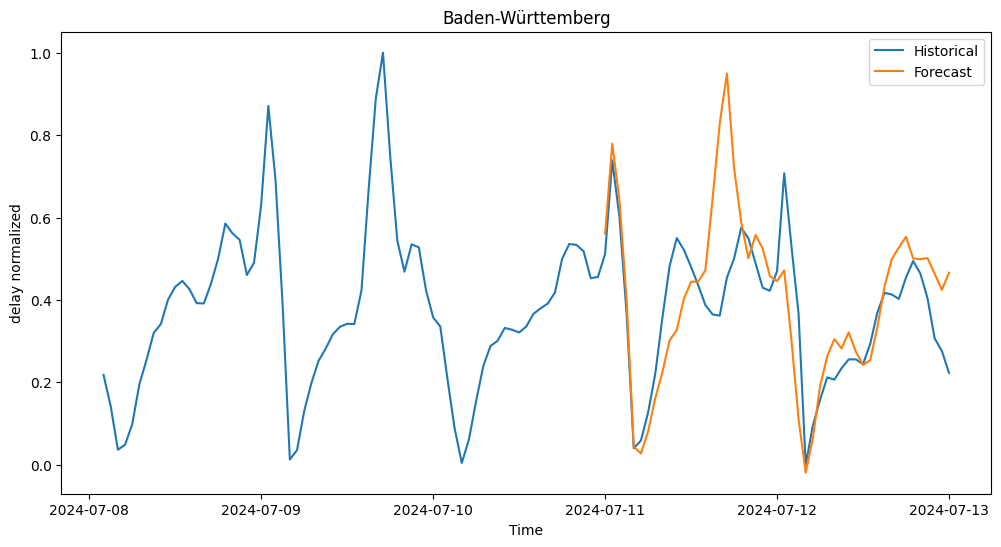

calc for Niedersachsen


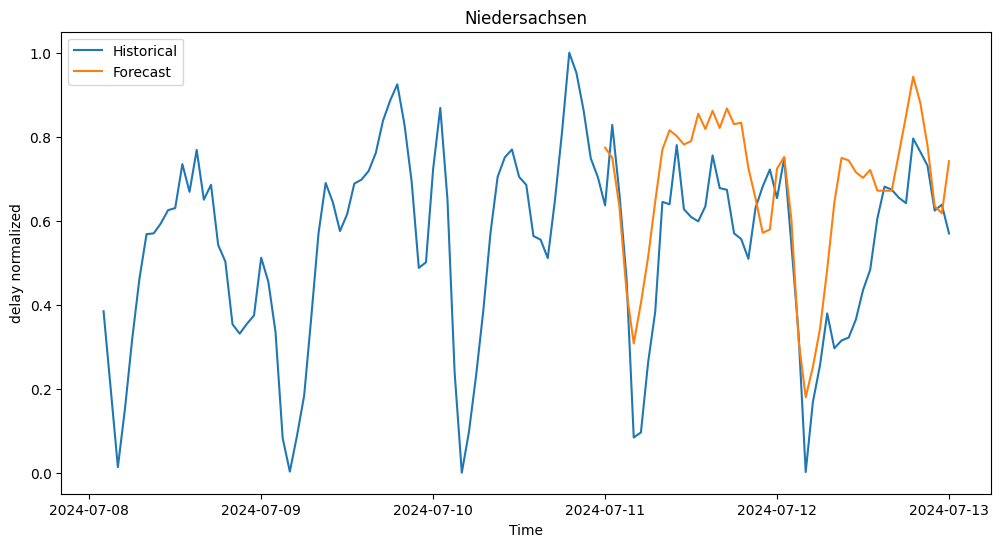

calc for Schleswig-Holstein


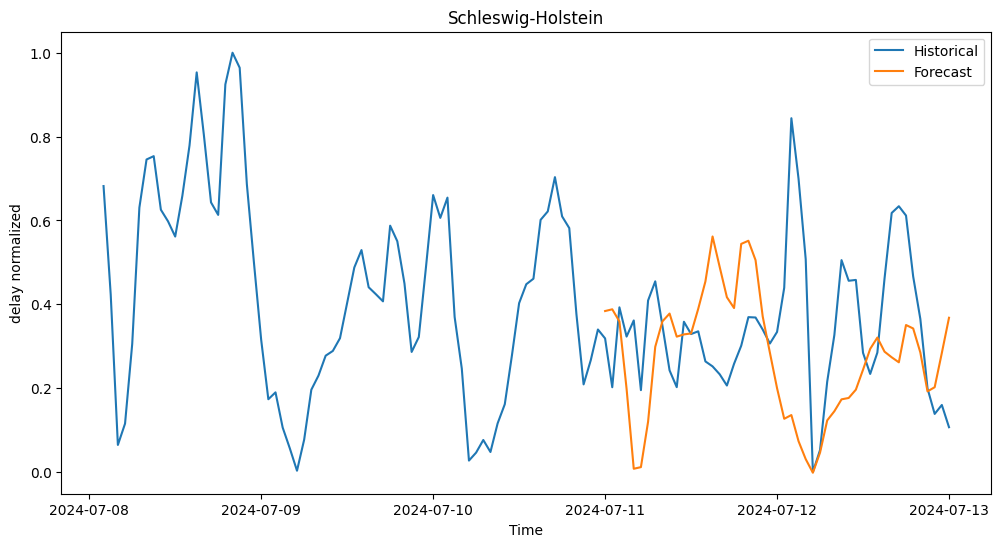

calc for Bayern


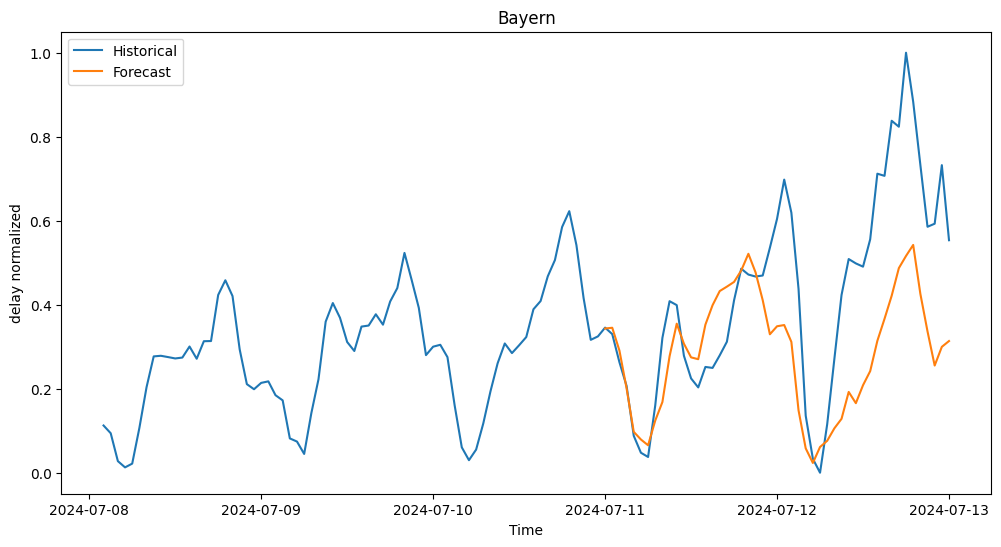

calc for Berlin


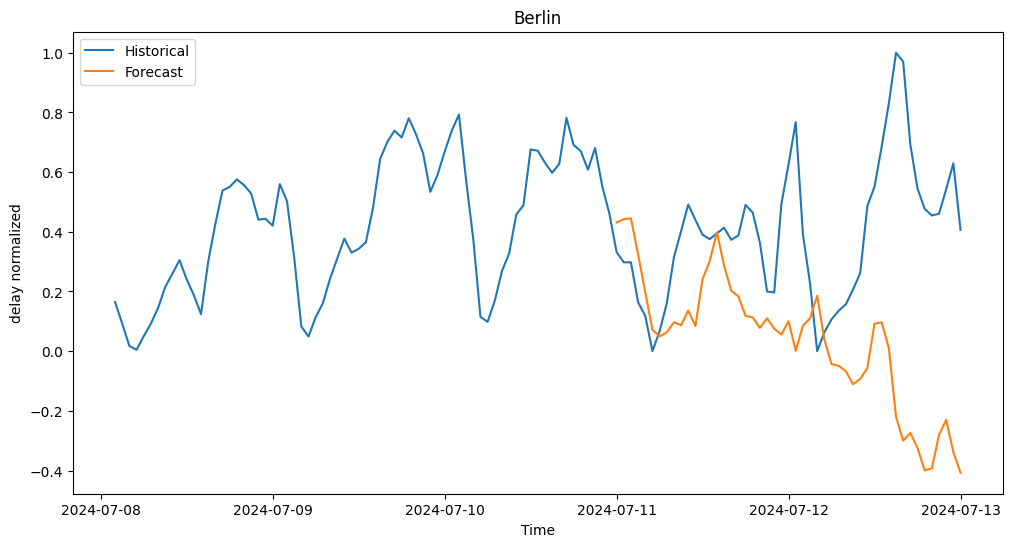

calc for Hamburg


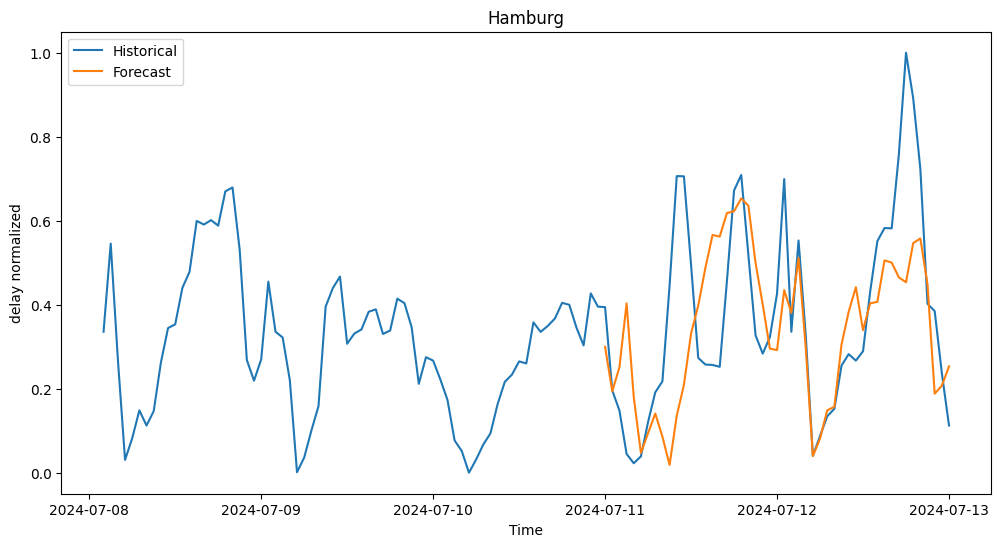

calc for Thüringen


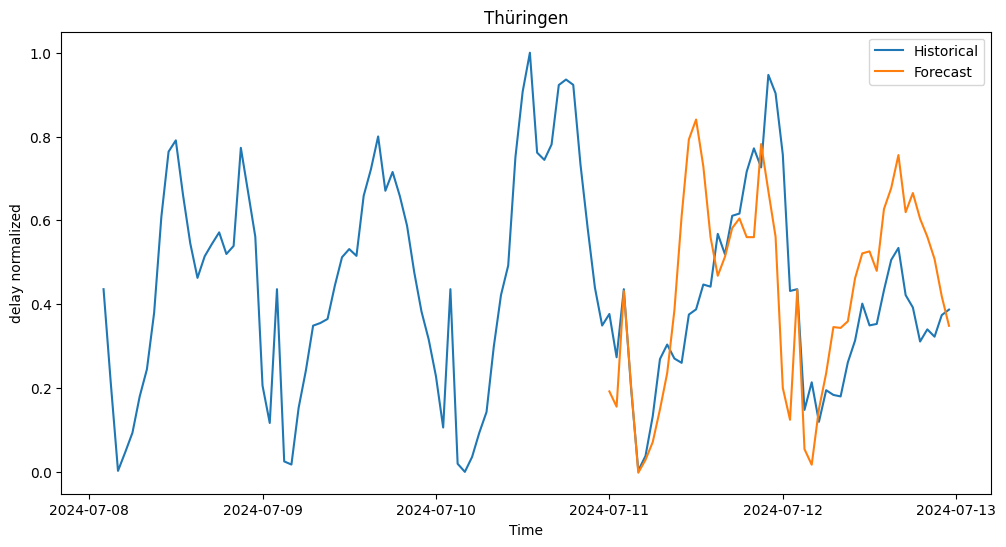

calc for Rheinland-Pfalz


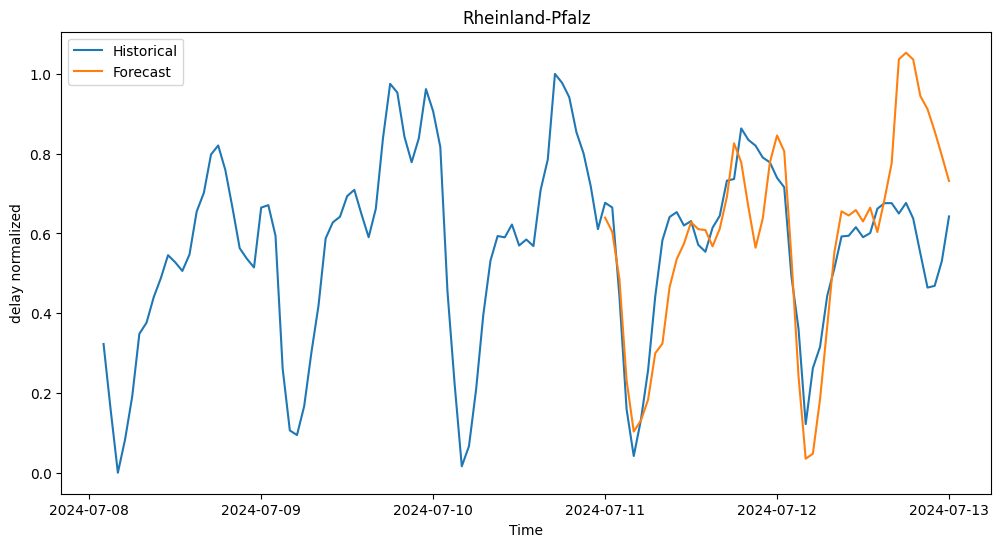

calc for Mecklenburg-Vorpommern


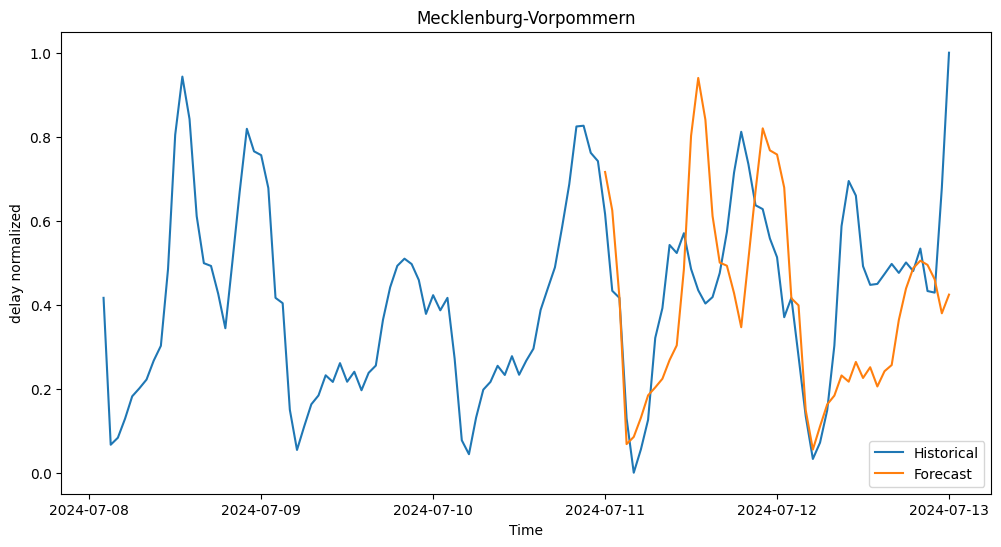

calc for Sachsen


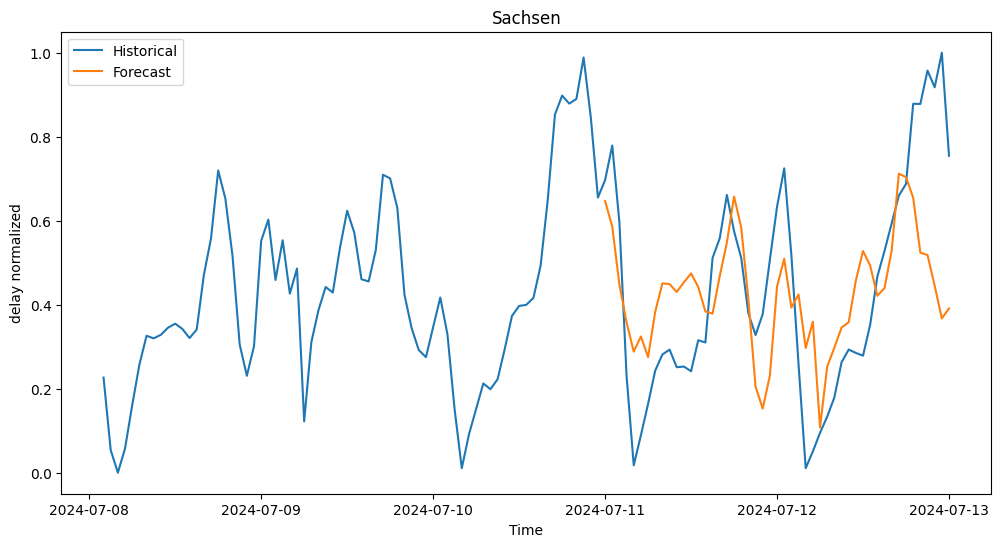

calc for Sachsen-Anhalt


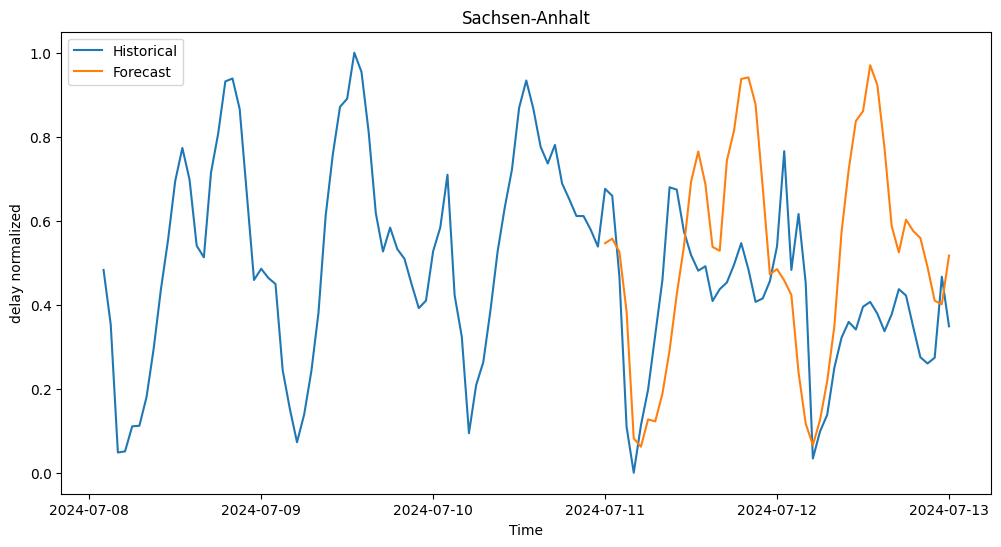

calc for Brandenburg


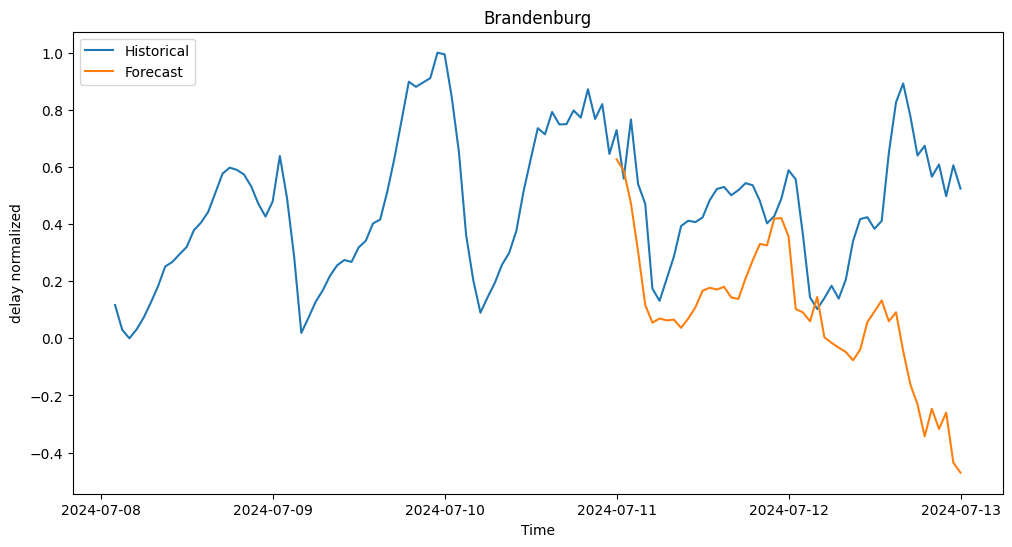

calc for Hessen


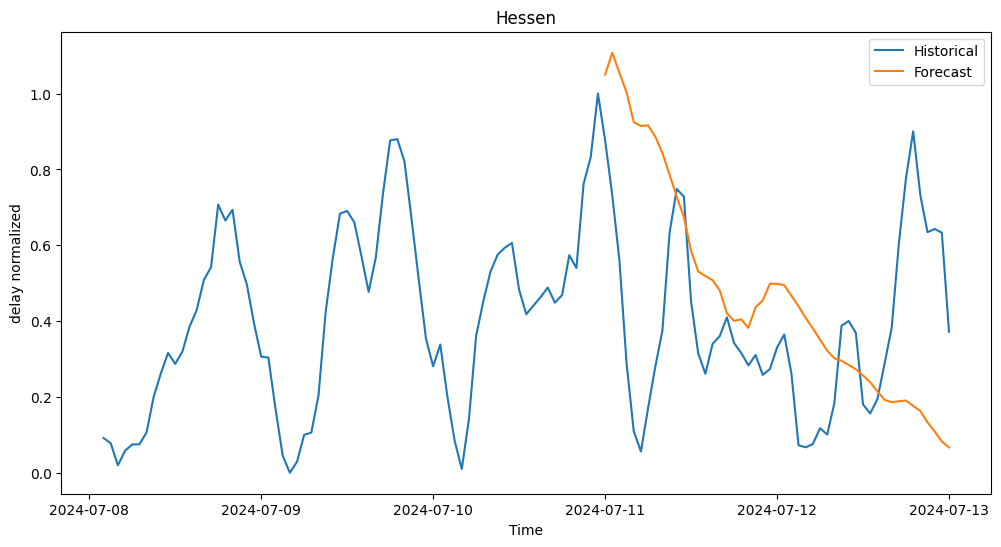

calc for Saarland


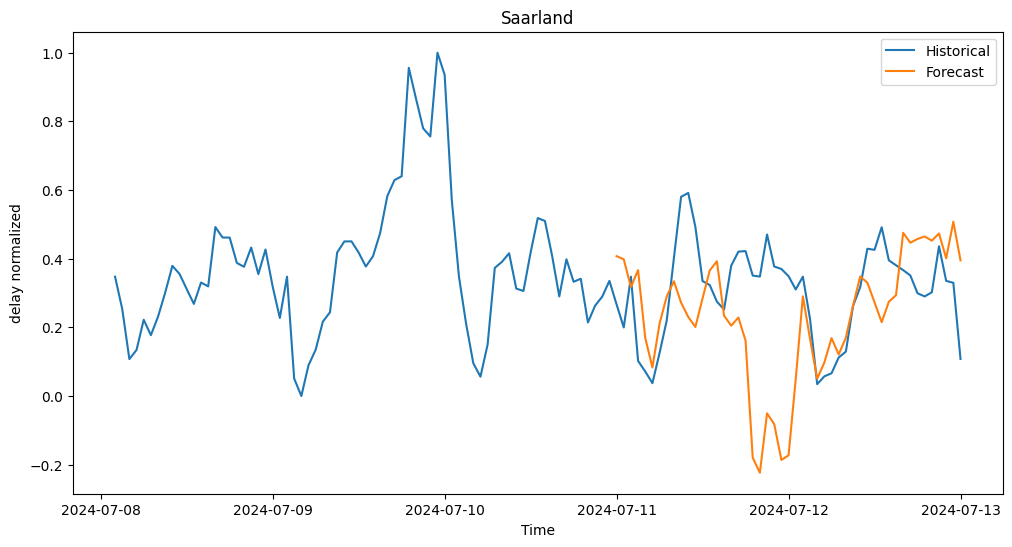

calc for Bremen


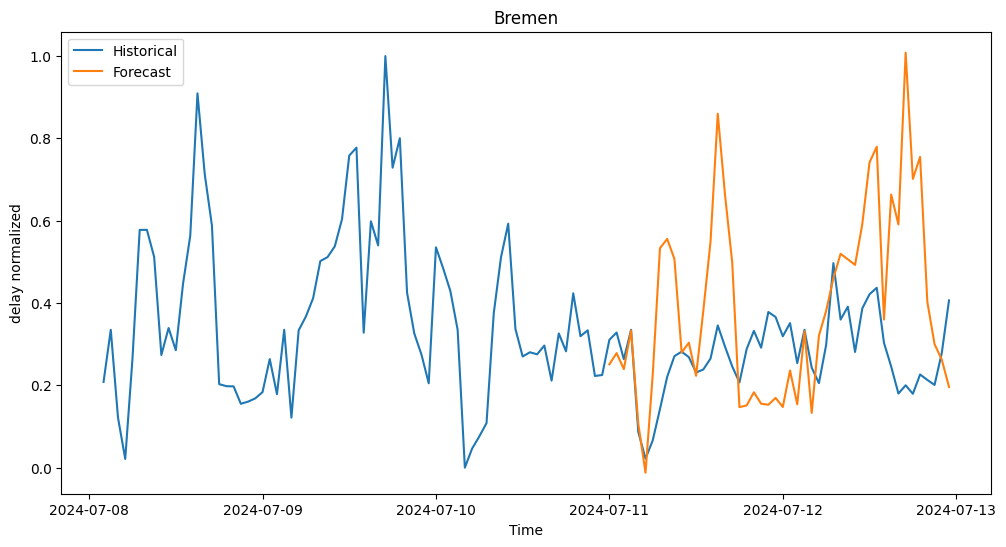

In [37]:
forecasts = {}
comparison = pd.DataFrame(columns=["rmse", "std"])

for state, data in frames_test.items():
    try:
        forecast_steps = frames_forecast_l[state]
        forecast = models[state].get_forecast(steps=forecast_steps)
        forecast_index = pd.date_range(start=data.index[0], periods=forecast_steps, freq='h')
        forecast_series = pd.Series(forecast.predicted_mean, index=forecast_index)
        #confidence_intervals = forecast.conf_int()
        print(f"calc for {state}")
        rmse = np.sqrt(mean_squared_error(data["departure_delay_m"], forecast_series))
        comparison.loc[state, "rmse"] = rmse
        comparison.loc[state, "std"] = frames_test[state].departure_delay_m.std()



        # Plot the forecast
        plt.figure(figsize=(12, 6))
        plt.plot(frames[state]['departure_delay_m'], label='Historical')
        plt.plot(forecast_series, label='Forecast')
        #plt.fill_between(forecast_index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='pink', alpha=0.3)
        plt.title(state)
        plt.xlabel('Time')
        plt.ylabel('delay normalized')
        plt.legend()
        plt.show()
    except:
        print(f"{state} is unpredictable")
        comparison.loc[state, "rmse"] = 1
        continue






In [38]:
comparison["predictability"] = comparison["std"] / comparison["rmse"]

In [39]:
comparison.sort_values("predictability", ascending=False)

,rmse,std,predictability
Sachsen,0.213234,0.261787,1.2277
Hamburg,0.206559,0.237429,1.149449
Baden-Württemberg,0.149205,0.164496,1.10248
Rheinland-Pfalz,0.173446,0.190528,1.098483
Bayern,0.225091,0.242067,1.075417
Niedersachsen,0.18795,0.20122,1.0706
Thüringen,0.202075,0.208322,1.030913
Mecklenburg-Vorpommern,0.234133,0.208553,0.890745
Schleswig-Holstein,0.236289,0.162474,0.687606
Nordrhein-Westfalen,0.254836,0.171019,0.671094
